# Acoustic Radiation Force using Perturbation Theory


In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns
from tqdm import tqdm

# The pressure field

From the acoustic wave equation

$$
\nabla^2 p_1 = \frac{1}{c_a^2}\partial_t p_1
$$

we can obtain the acosutic resonant modes which are particulary usefull to establish the acousctic manipulation of particules in microfluidic systems of determined geometries. In particular,  the resonant modes for a rectangular water-filled channel placed along the coordinated axis with its opposite corners at (0,0,0) and ($l$,$w$,$h$) parameters surrounded by either hard or soft walls is defined as:

$$
p_1(x,y,z) = p_asin(k_x x)sin(k_y y) sin(k_z z)
$$

with $k_j = n_j\frac{\pi}{L_j}$ for soft wall condition, and:

$$
p_1(x,y,z) = p_acos(k_x x)cos(k_y y)cos(k_z z)
$$

with $k_j = n_j\frac{\pi}{L_j}$ for hard wall condition, where $p_a$ is the preassure amplitude, $(L_x,L_y,Lz) = (l,w,h)$ and $n_j = (0),1,2,..$ is the number of half wavelengths in the system ($n_j >0$ for the sine-waves). Therefore, the corresponding three-index resonance frequencies, $f_{n_x,n_y,n_z}= \omega_{n_x,n_y,n_z}/2\pi$ are:

$$
f_{n_x,n_y,n_z} = \frac{c_{water}}{2}\sqrt{\frac{n_x^2}{l^2}+\frac{n_y^2}{w^2}+\frac{n_z^2}{h^2}}
$$

In [2]:
# Definition of the acoustic force simulation object
class AcousticPT:
    
    def __init__(self, variable, condition='soft-wall',**kwargs):
        """
        The object instance is created. 
        
        The type of experimental variable and the model parameters
        are selecto choosing between particle material and size, 
        type of wall condition and microchip geometry.
        Parameters
        ------------
        variable(str) := 'radii', 'material', 'medium', 'modes', 'frequency'
                            variables for experimentation
        condition(str) := 'soft-wall', 'hard-wall'
                            type of boundary condition on the chip
        kwargs(dict) := {'a': p. radius [m], l': chip's length [m], 'w': chip's width [m], 
                            'h': chip's height [m], 'pa': preassure amplitude [Pa], 
                            'f': acoustic frecuency [Hz], 'medium': medium material,
                            'material': p. material, 'n_points': size of samplings}
        Material velocities recovered from https://www.olympus-ims.com/en/ndt-tutorials/thickness-gauge/appendices-velocities/
        https://iopscience.iop.org/article/10.1088/1361-6560/aa6226#:~:text=Our%20approach%20enables%20an%20accurate,0%25%20to%2080%25%20respectively.
        https://www.researchgate.net/figure/Physical-constants-for-phosphate-buffered-saline-with-05-w-v-albumin-solution_tbl1_258827391
        https://www.ias.ac.in/article/fulltext/seca/009/04/0312-0315
        https://www.sciencedirect.com/science/article/abs/pii/0041624X92900943
        
        """
        self.variable = variable
        self.condition = condition
        # materials sound velocity
        self.materials_velocity = {'latex':1610, 'silica':9620, 'oil':1469, 'liver': 1492}
        self.materials_density = {'latex': 1050, 'silica': 2000, 'oil':1020, 'liver': 1070}    # kg/m3
        # mediums sound velocity
        self.mediums_velocity = {'water': 1480, 'air': 348, 'glycerol': 1957,'PBS':1505} #m/s
        self.mediums_density = {'water': 1000, 'air': 1.225, 'glycerol': 1260, 'PBS':1062}
        self.param  = {'a': 10e-6, 'l': 10e-3 , 'w': 10e-3, 
                            'h': 1e-3, 'pa': 1, 
                            'nx': 1, 'ny': 1 , 'nz': 1, 'medium': 'water',
                            'material': 'silica', 'n_points': 250}
        # The p dictionary will store and update the parameters according
        # to the user in **kwars
        for key, value in kwargs.items():
            if key in list(self.param.keys()):
                self.param[key] = value    # Update the simulation parameters
            else:
                raise KeyError('Select a valid parameter.')
        # Get the compressibility given the material and the medium
        if self.param['material'] in self.materials_velocity:
            mat = self.param['material']
            self.param['k_t'] = 1/((self.materials_velocity[mat]**2)*self.materials_density[mat])    #Compressibility of the material
        else:
            raise KeyError('Select a valid material. The allowed materials are: latex,sillica, glass, oil or liver')
        if self.param['medium'] in self.mediums_velocity:
            med = self.param['medium']
            self.param['k_i'] = 1/((self.mediums_velocity[med]**2)*self.mediums_density[med])    #Compressibility of the medium
            arg = (self.param['nx']/self.param['l'])**2 +(self.param['ny']/self.param['w'])**2+ (self.param['nz']**2/self.param['h'])**2
            self.param['f'] = (self.mediums_velocity[med]/2)*np.sqrt(arg)   #Frequency of the wave to get the given resonance modes
        else:
            raise KeyError('Select a valid medium. The allowed mediyms are: water, air, glycerol')
        
        #Verify number of wavelenghts
        if self.param['nx'] == 0 and self.condition == 'soft-wall':
            raise ValueError('In soft wall condition nj > 0')
        elif self.param['ny'] == 0 and self.condition == 'soft-wall':
            raise ValueError('In soft wall condition nj > 0')
        elif self.param['nz'] == 0 and self.condition == 'soft-wall':
            raise ValueError('In soft wall condition nj > 0')

        print('AcousticPTmodel_condition-{c}'.format(
            c = condition
        ))
    def update_params(self,**kwargs):
        # The p dictionary will store and update the parameters according
        # to the user in **kwars
        for key, value in kwargs.items():
            if key in list(self.param.keys()):
                self.param[key] = value    # Update the simulation parameters
            else:
                raise KeyError('Select a valid parameter. The allowed parameters are: a, NA, R, etc.')
        # Get the compressibility given the material and the medium
        
        if self.param['material'] in self.materials_velocity:
            mat = self.param['material']
            self.param['k_0'] = 1/((self.materials_velocity[mat]**2)*self.materials_density[mat])
        else:
            raise KeyError('Select a valid material. The allowed materials are: latex,sillica, glass, oil or liver')
        if self.param['medium'] in self.mediums_velocity:
            med = self.param['medium']
            self.param['k_p'] = 1/((self.mediums_velocity[med]**2)*self.mediums_density[med])
            arg = (self.param['nx']**2/self.param['l']) +(self.param['ny']**2/self.param['w'])+ (self.param['nz']**2/self.param['h'])
            self.param['f'] = (self.mediums_velocity[med]/2)*np.sqrt(arg)
        else:
            raise KeyError('Select a valid medium. The allowed mediyms are: water, air, glycerol')
        #Verify number of wavelenghts
        if self.param['nx'] == 0 and self.condition == 'soft-wall':
            raise ValueError('In soft wall condition nj > 0')
        elif self.param['ny'] == 0 and self.condition == 'soft-wall':
            raise ValueError('In soft wall condition nj > 0')
        elif self.param['nz'] == 0 and self.condition == 'soft-wall':
            raise ValueError('In soft wall condition nj > 0')
            
    def preassure_f (self,x,y,z):
        p = self.param
        l,w,h = p['l'],p['w'],p['h']
        nx,ny,nz = self.param['nx'], self.param['ny'], self.param['nz']
        kx,ky,kz = nx*np.pi/l, ny*np.pi/w, nz*np.pi/h
        self.kx, self.ky, self.kz = kx, ky, kz
        if self.condition == 'soft-wall':
            p1 = self.param['pa']*np.sin(kx*x)*np.sin(ky*y)*np.sin(kz*z)
        elif self.condition == 'hard-wall':
            p1 = self.param['pa']*np.cos(kx*x)*np.cos(ky*y)*np.cos(kz*z)
        return p1
    
            
    def velocity_f(self,x,y,z):
        p = self.param
        l,w,h = p['l'],p['w'],p['h']
        nx,ny,nz = self.param['nx'], self.param['ny'], self.param['nz']
        kx,ky,kz = nx*np.pi/l, ny*np.pi/w, nz*np.pi/h
        if self.condition == 'soft-wall':
            v1_x = self.param['pa']*kx*np.cos(kx*x)*np.sin(ky*y)*np.sin(kz*z)
            v1_y = self.param['pa']*ky*np.sin(kx*x)*np.cos(ky*y)*np.sin(kz*z)
            v1_z = self.param['pa']*kz*np.sin(kx*x)*np.sin(ky*y)*np.cos(kz*z)
            v1 = np.array([v1_x,v1_y,v1_z])
        elif self.condition == 'hard-wall':
            v1_x = -self.param['pa']*kx*np.sin(kx*x)*np.cos(ky*y)*np.cos(kz*z)
            v1_y = -self.param['pa']*ky*np.cos(kx*x)*np.sin(ky*y)*np.cos(kz*z)
            v1_z = -self.param['pa']*kz*np.cos(kx*x)*np.cos(ky*y)*np.sin(kz*z)
            v1 = np.array([v1_x,v1_y,v1_z])
        return v1
    
    def plot_preassure(self,x_plane,norm=False,**kwargs):
        p = self.param
        l,w,h = p['l'],p['w'],p['h']
        nx,ny,nz = self.param['nx'], self.param['ny'], self.param['nz']
        kx,ky,kz = nx*np.pi/l, ny*np.pi/w, nz*np.pi/h
        z = np.linspace(0,h,p['n_points'])
        y = np.linspace(0,w,p['n_points'])
        Y,Z = np.meshgrid(y,z)
        X = self.preassure_f(x_plane,Y,Z)
        fig = plt.figure()
        if norm == True:
            norm_val = np.reshape(self.preassure_f(l/2,Y,Z),(-1,p['n_points']**2))
            levels = np.linspace(norm_val.min(),norm_val.max(),10)
            CF = plt.contourf(Z,Y,X, levels=levels)
        else:
            CF = plt.contourf(Z,Y,X)
        plt.xlabel('y')
        plt.ylabel('z')
        plt.title(f'Plane x {x_plane}')
        cbar = fig.colorbar(CF)
        plt.show()
    def plot_velocity(self,x_plane,**kwargs):
        p = self.param
        l,w,h = p['l'],p['w'],p['h']
        nx,ny,nz = self.param['nx'], self.param['ny'], self.param['nz']
        kx,ky,kz = nx*np.pi/l, ny*np.pi/w, nz*np.pi/h
        z = np.linspace(0,h,p['n_points'])
        y = np.linspace(0,w,p['n_points'])
        Y,Z = np.meshgrid(y,z)
        X = self.velocity_f(x_plane,Y,Z)
        u = X[0]
        v = X[1]
        fig = plt.figure()
        plt.quiver(Y,Z,u,v)
        plt.xlabel('y')
        plt.ylabel('z')
        plt.title(f'Plane x {x_plane}')
        plt.show()
    
    def plot_fields(self,x_plane,**kwargs):
        parameters = {'figsize': (16,6), 'colormap': 'Spectral', 'normalize': False}
        for key, value in kwargs.items():
            parameters[key] = value
        p = self.param
        l,w,h = p['l'],p['w'],p['h']
        nx,ny,nz = self.param['nx'], self.param['ny'], self.param['nz']
        kx,ky,kz = nx*np.pi/l, ny*np.pi/w, nz*np.pi/h
        fig,ax = plt.subplots(1,2,figsize=parameters['figsize'])
        z = np.linspace(0,h,p['n_points'])
        y = np.linspace(0,w,p['n_points'])
        Y,Z = np.meshgrid(y,z)
        X = self.velocity_f(x_plane,Y,Z)
        u = X[0]
        v = X[1]
        ax[0].quiver(Y,Z,u,v)
        
        
        X = self.preassure_f(x_plane,Y,Z)
        if parameters['normalize'] == True:
            norm_val = np.reshape(self.preassure_f(l/2,Y,Z),(-1,p['n_points']**2))
            levels = np.linspace(norm_val.min(),norm_val.max(),10)
            CF = ax[1].contourf(Z,Y,X, levels=levels)
        else:
            CF = ax[1].contourf(Z,Y,X,cmap=parameters['colormap'])
        cbar = fig.colorbar(CF)
        plt.show()
    
    def acoustic_force(self,r_i, r_f, **kwargs):
        self.update_params(**kwargs)
        self.r_i = r_i
        self.r_f = r_f
        p = self.param
        '''Data preparation'''
        #  Model dictionary will store the useful results
        model = {'positions':{},'results':{}}
        # Get the positions vectors
        n = p['n_points']
        z = np.linspace(r_i[2],r_f[2],n)
        y = np.linspace(r_i[1],r_f[1],n)
        x = np.linspace(r_i[0],r_f[0],n)
        # Store them in the model dictionary
        model['positions']['x'] = x
        model['positions']['y'] = y
        model['positions']['z'] = z
        # Create the 3D-force results array
        F_tot = np.zeros((3,n))
        '''U potential'''
        # Get the parameters from dictionary
        a, f, k_p, k_0 = p['a'], p['f'], p['k_p'], p['k_0']
        rho_p, rho_0 = self.materials_density[p['material']], self.mediums_density[p['medium']]
        tavg_scalar = lambda f: 0.5*np.real(f**2)
        tavg_vector = lambda g: 0.5*np.real(g)
        k_hat = k_p/k_0
        rho_hat = rho_p/rho_0
        f1 = 1-k_hat
        f2 = 2*(rho_hat-1)/(2*rho_hat + 1)
        X,Y,Z  = np.meshgrid(x,y,z)
        def U (x,y,z):
            # x,y,z must be meshgrid coord
            pin = self.preassure_f(x,y,z)
            vin = self.velocity_f(x,y,z)
            vin_mag = vin[0,:,:,:]**2 + vin[1,:,:,:]**2 +vin[2,:,:,:]**2  #which one?
#             vin_mag = vin[0,:,:,:] + vin[1,:,:,:] +vin[2,:,:,:]
            U=(4*np.pi/3)*(a**3)*(f1*(k_0/2)*tavg_scalar(pin) - f2*(3*rho_0*0.5/4)*vin_mag)
            return U
    
        def gradient(U,x,y,z):
            n = len(x)
            partial_xgrid = np.zeros([n,n,n])
            partial_ygrid = np.zeros([n,n,n])
            partial_zgrid = np.zeros([n,n,n])
            delta_x = x[1] - x[0]
            delta_y = y[1] - y[0]
            delta_z = z[1] - z[0]
            for i in tqdm(range(1,len(x)-1)):
                for j in range(1,len(y)-1):
                    for k in range(1,len(z)-1):
                        partial_zgrid[i,j,k] = (U[i,j,k+1]-U[i,j,k-1])/2*delta_z
            for i in tqdm(range(1,len(z)-1)):
                for j in range(1,len(x)-1):
                    for k in range(1,len(y)-1):
                        partial_ygrid[i,j,k] = (U[i,j+1,k]-U[i,j-1,k])/2*delta_y
            for i in tqdm(range(1,len(y)-1)):
                for j in range(1,len(z)-1):
                    for k in range(1,len(x)-1):
                        partial_xgrid[i,j,k] = (U[i+1,j,k]-U[i-1,j,k])/2*delta_x
            grad = -np.array([partial_xgrid, partial_ygrid, partial_zgrid])
            return grad
        model['results']['total'] = gradient(U(X,Y,Z),x,y,z)
        model['results']['potential'] = U(X,Y,Z)
        # Store the parameters used 
        model['parameters'] = p
        self.model = model
        return model
    

In [3]:
ac = AcousticPT('radii',condition='soft-wall')

AcousticPTmodel_condition-soft-wall


In [4]:
ac.param

{'a': 1e-05,
 'l': 0.01,
 'w': 0.01,
 'h': 0.001,
 'pa': 1,
 'nx': 1,
 'ny': 1,
 'nz': 1,
 'medium': 'water',
 'material': 'silica',
 'n_points': 250,
 'k_t': 5.402812055618708e-12,
 'k_i': 4.5653761869978085e-10,
 'f': 747363.3654387938}

In [5]:
r_i = [0,0,0]
r_f = [0.01,0.1,0.001]
t = ac.acoustic_force(r_i,r_f,n_points=250)

100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:25<00:00,  9.80it/s]


In [6]:
t['results']['total'].shape

(3, 250, 250, 250)

Text(0, 0.5, 'Force [pN]')

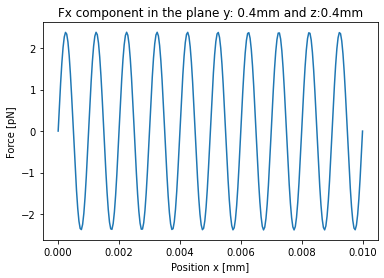

In [7]:
y_plane = 100
z_plane = 100
plt.plot(t['positions']['x'], t['results']['total'][0][:,y_plane,z_plane]*1e12)
plt.title(f'Fx component in the plane y: {np.round(y_plane/250,2)}mm and z:{np.round(z_plane/250,2)}mm')
plt.xlabel('Position x [mm]')
plt.ylabel('Force [pN]')

Text(0, 0.5, 'Force [pN]')

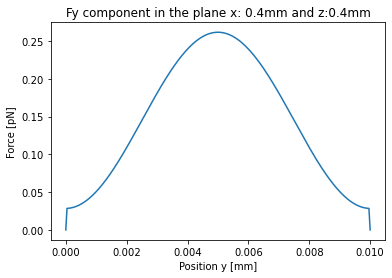

In [97]:
x_plane = 100
z_plane = 100
plt.plot(t['positions']['x'], t['results']['total'][x_plane,:,z_plane]*1e12)
plt.title(f'Fy component in the plane x: {np.round(x_plane/250,2)}mm and z:{np.round(z_plane/250,2)}mm')
plt.xlabel('Position y [mm]')
plt.ylabel('Force [pN]')

Text(0, 0.5, 'Force [pN]')

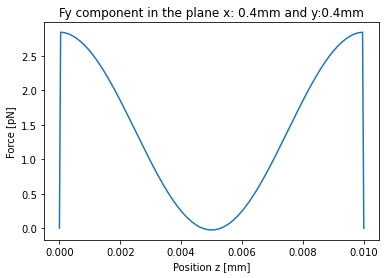

In [98]:
x_plane = 100
y_plane = 100
plt.plot(t['positions']['x'], t['results']['total'][x_plane,y_plane,:]*1e12)
plt.title(f'Fy component in the plane x: {np.round(x_plane/250,2)}mm and y:{np.round(y_plane/250,2)}mm')
plt.xlabel('Position z [mm]')
plt.ylabel('Force [pN]')

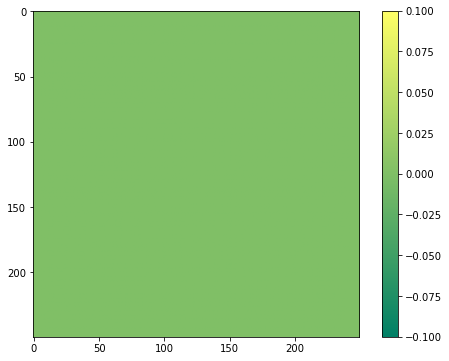

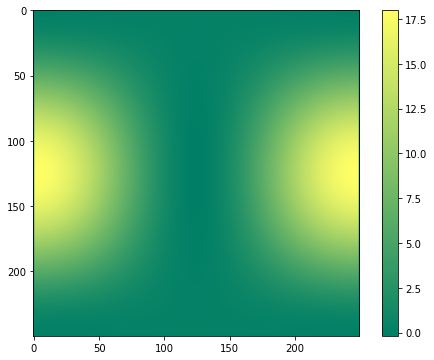

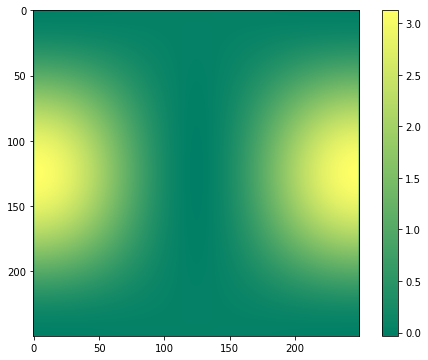

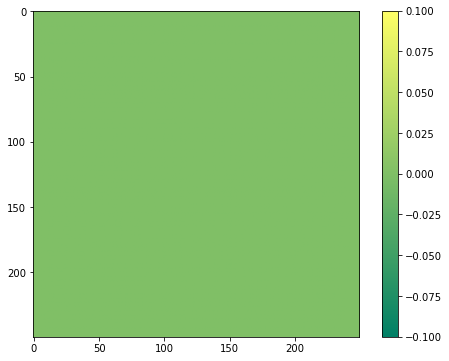

In [81]:
# Force field given j-planes
for i in [0,10,100,249]:
    plt.figure(figsize=(8,6))
    plt.imshow(t['results']['total'][0][i,:,:]*1e12,cmap='summer')
    plt.colorbar()
    plt.show()

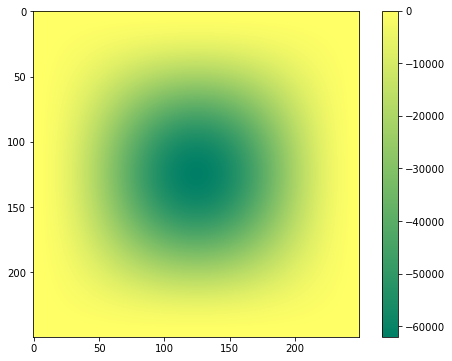

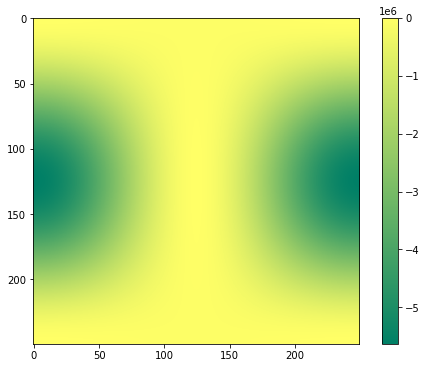

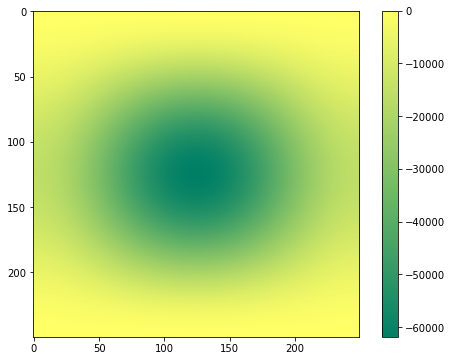

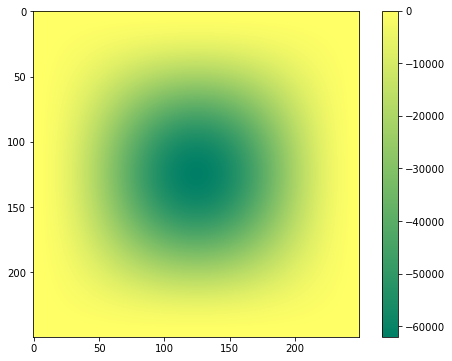

In [99]:
# U scalar field givenj-plane
for i in [0,10,100,249]:
    plt.figure(figsize=(8,6))
    plt.imshow(t['results']['potential'][i,:,:]*1e12,cmap='summer')
    plt.colorbar()
    plt.show()

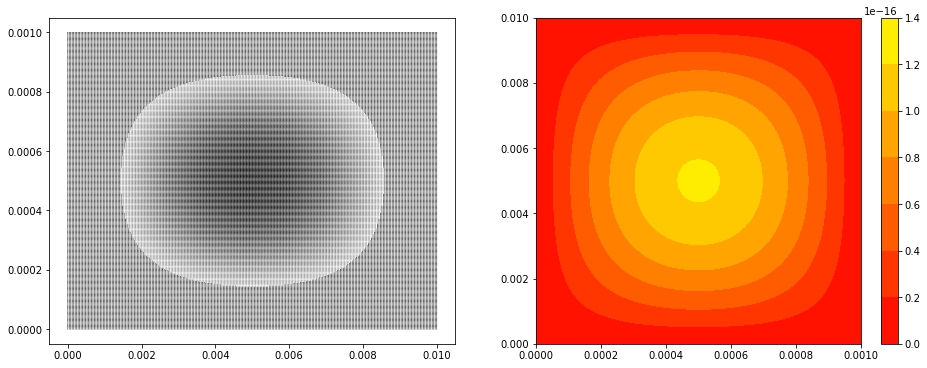

In [61]:
ac.plot_fields(x_plane=0.01,colormap='autumn')

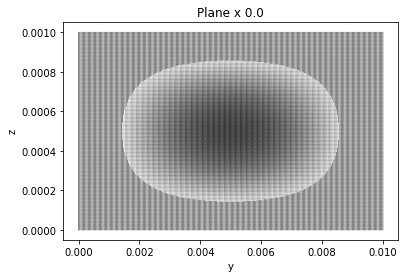

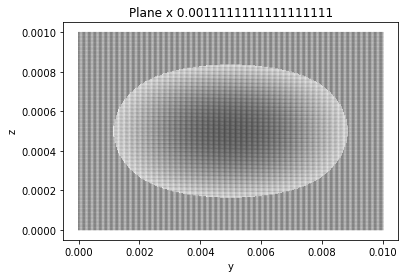

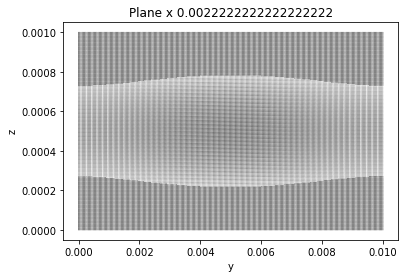

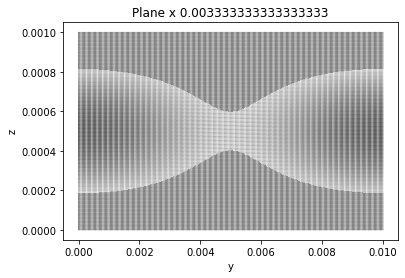

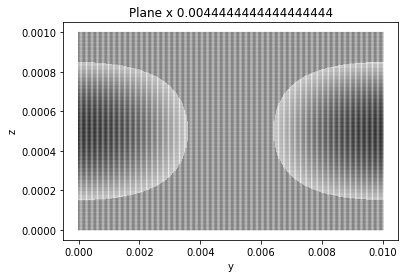

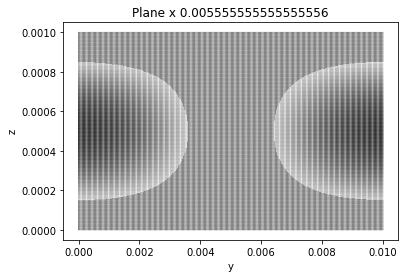

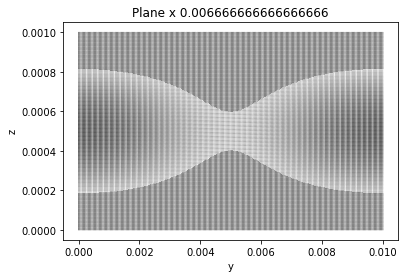

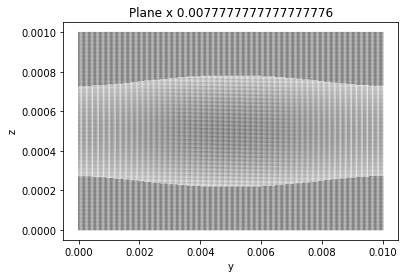

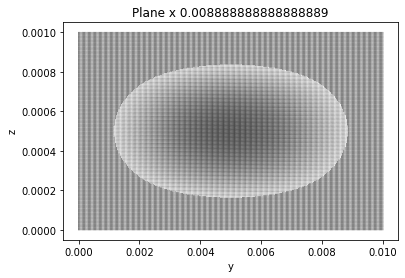

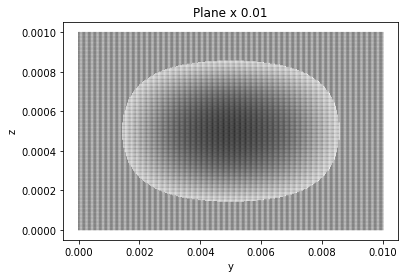

In [62]:
x = np.linspace(0,0.01,10)
for x_ in x:
    ac.plot_velocity(x_plane=x_)

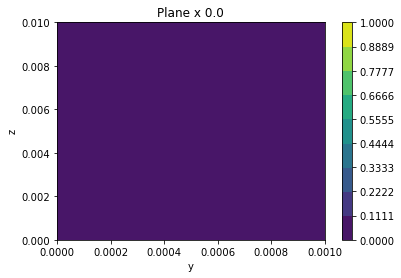

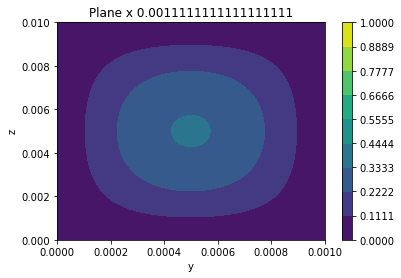

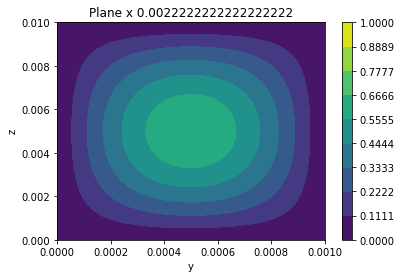

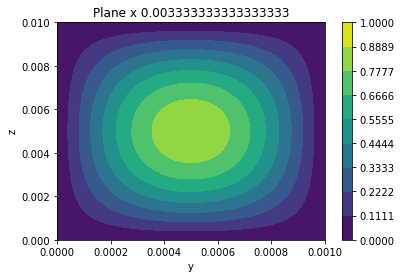

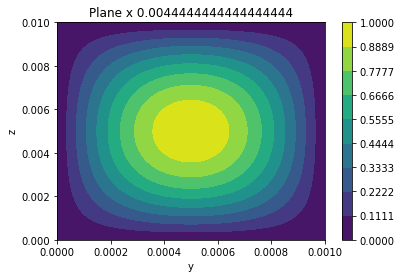

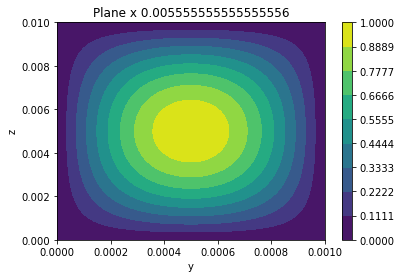

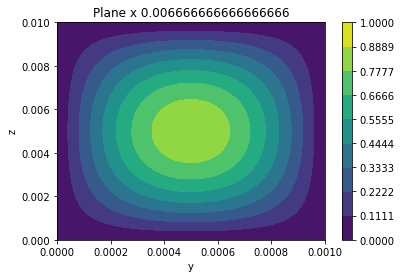

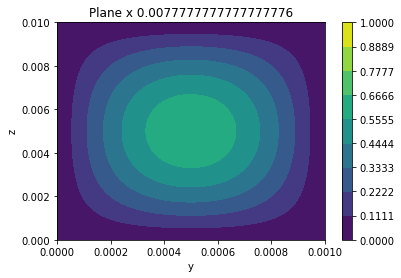

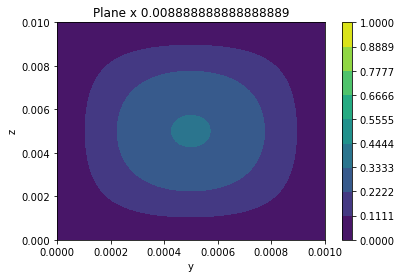

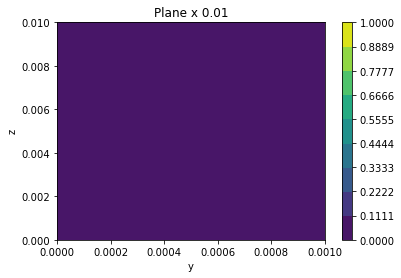

In [175]:
%matplotlib inline
x = np.linspace(0,0.01,10)
for x_ in x:
    ac.plot_preassure(x_plane=x_,norm=True)

## Trying multiple particle sizes

In [8]:
a_values = np.array([10,15,20,25,50])*1e-6
results = {}
r_i = [0,0,0]
r_f = [0.01,0.1,0.001]
for a in a_values:
    acoustic = AcousticPT('radii',condition='soft-wall',a=a)
    results[a] = acoustic.acoustic_force(r_i,r_f,n_points=250)

AcousticPTmodel_condition-soft-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:28<00:00,  8.60it/s]


AcousticPTmodel_condition-soft-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:28<00:00,  8.66it/s]


AcousticPTmodel_condition-soft-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:25<00:00,  9.87it/s]


AcousticPTmodel_condition-soft-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:24<00:00, 10.02it/s]


AcousticPTmodel_condition-soft-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:24<00:00,  9.96it/s]


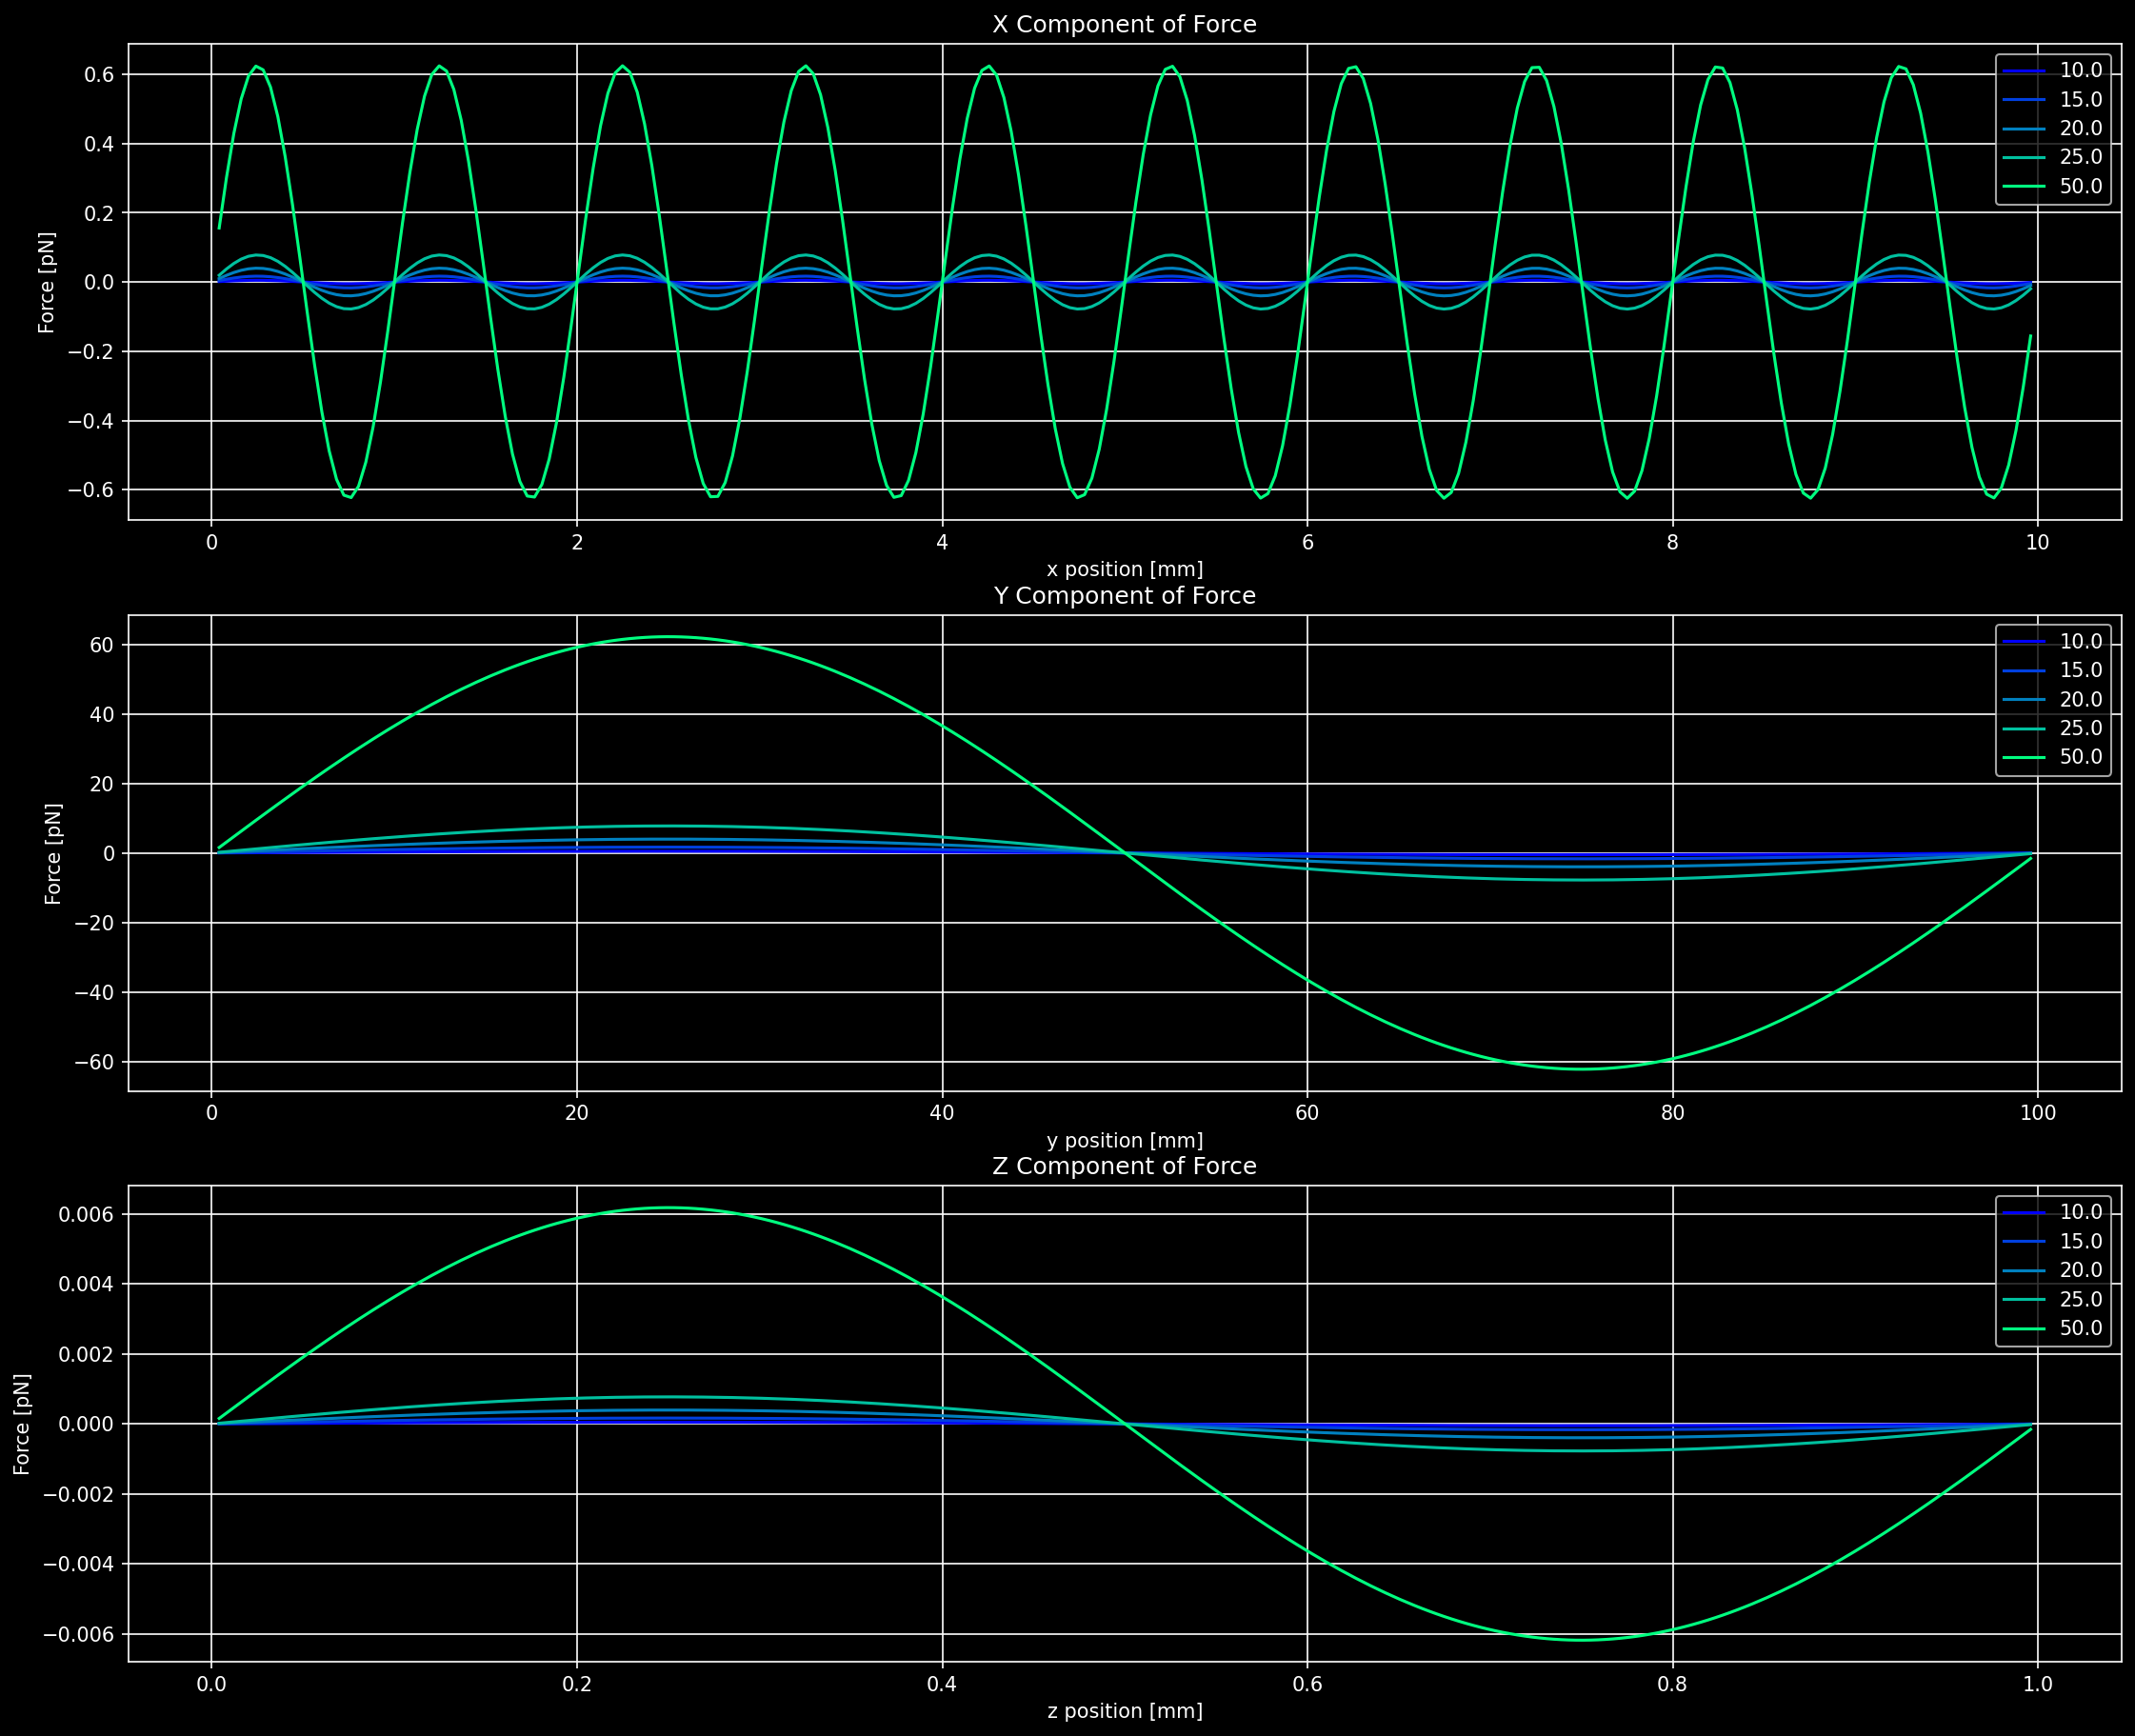

In [11]:
from mycolorpy import colorlist as mcp
plt.rcParams['figure.dpi'] = (150)
plt.style.use('dark_background')
fig,ax = plt.subplots(3,1, figsize=(18,15))
colormap = mcp.gen_color(cmap='winter',n=(len(a_values)))
plane_val = 1
# fig.suptitle(f'Multiple radii @ according plane {np.round(plane_val/250,2)} mm')
i = 0
for a in results.keys():
    ax[0].plot(results[a]['positions']['x'][1:-1]*1e3,results[a]['results']['total'][0][:,plane_val,plane_val][1:-1]*1e12,
              label=f'{np.round(a*1e6)}',c=colormap[i])
    ax[1].plot(results[a]['positions']['y'][1:-1]*1e3,results[a]['results']['total'][1][plane_val,:,plane_val][1:-1]*1e12,
              label=f'{np.round(a*1e6)}',c=colormap[i])
    ax[2].plot(results[a]['positions']['z'][1:-1]*1e3,results[a]['results']['total'][2][plane_val,plane_val,:][1:-1]*1e12,
              label=f'{np.round(a*1e6)}',c=colormap[i])
    i+=1
comp_lab = {0:'x',1:'y',2:'z'}
for i in range(3):
    ax[i].set_xlabel(f'{comp_lab[i]} position [mm]')
    ax[i].set_title(f'{comp_lab[i].upper()} Component of Force')
    ax[i].set_ylabel('Force [pN]')
    ax[i].legend()
    ax[i].grid()
plt.show()

In [185]:
a_values = np.array([10,15,20,25,50])*1e-6
results = {}
r_i = [0,0,0]
r_f = [0.01,0.1,0.001]
acoustic = AcousticPT('radii',condition='soft-wall',a=a_values[0])
ac_2 = acoustic.acoustic_force(r_i,r_f,n_points=250)

AcousticPTmodel_condition-soft-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:34<00:00,  7.11it/s]


In [186]:
acoustic.param

{'a': 9.999999999999999e-06,
 'l': 0.01,
 'w': 0.01,
 'h': 0.001,
 'pa': 1,
 'nx': 1,
 'ny': 1,
 'nz': 1,
 'medium': 'water',
 'material': 'silica',
 'n_points': 250,
 'k_t': 5.402812055618708e-12,
 'k_i': 4.5653761869978085e-10,
 'f': 25634.351952019388,
 'k_0': 5.402812055618708e-12,
 'k_p': 4.5653761869978085e-10}

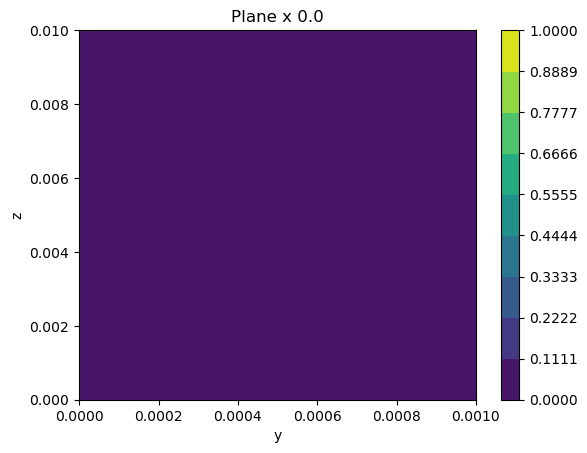

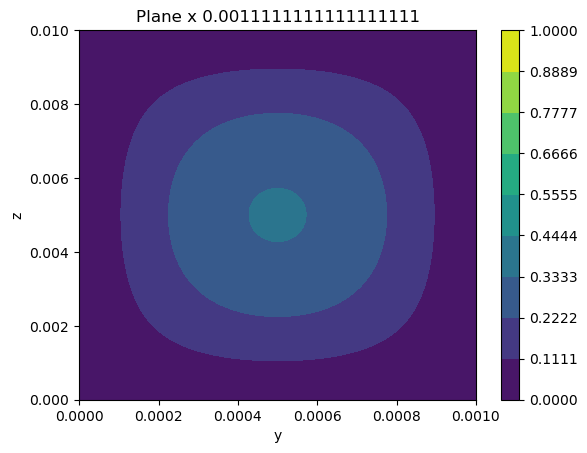

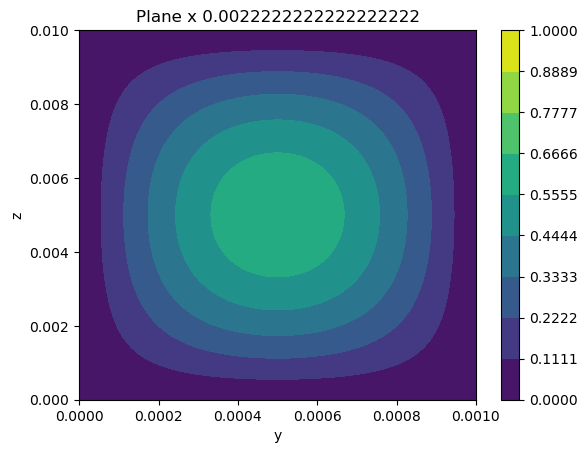

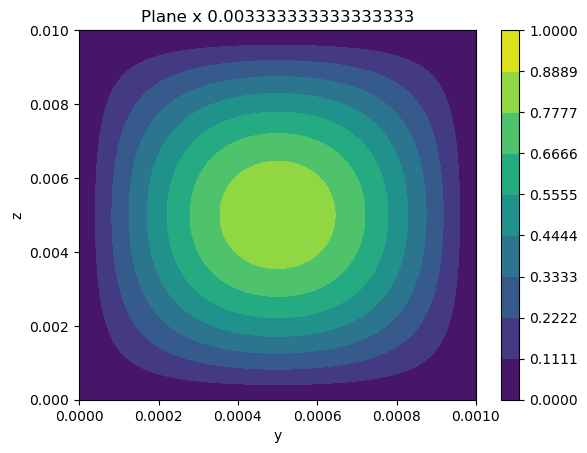

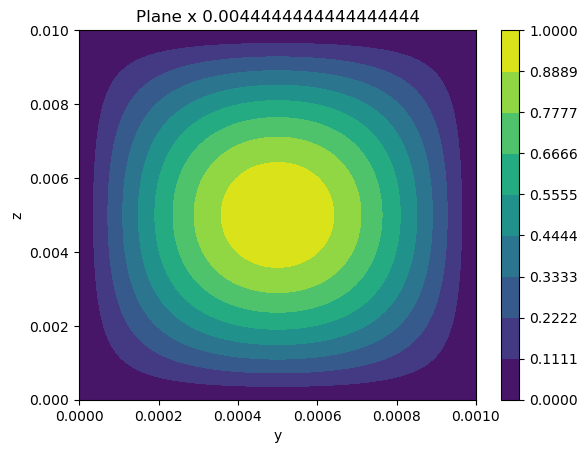

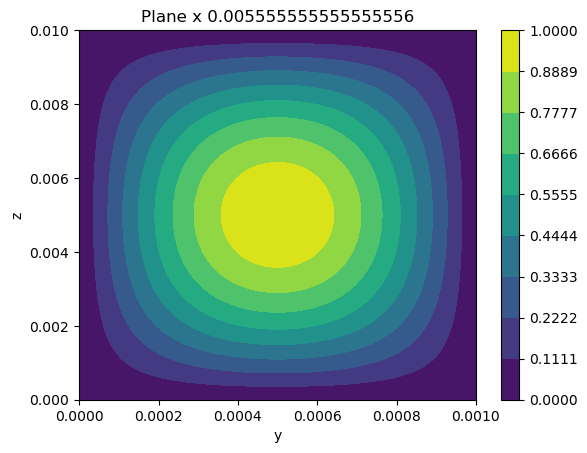

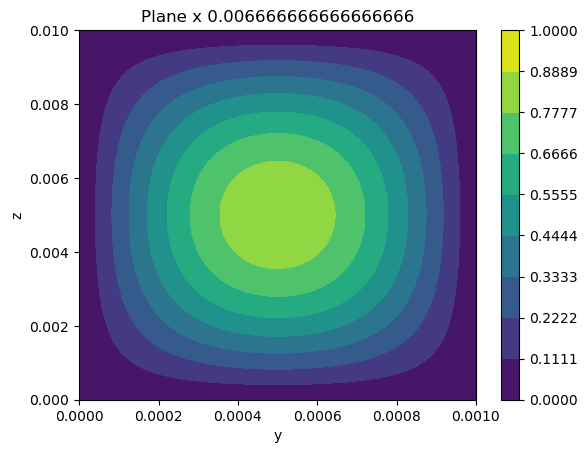

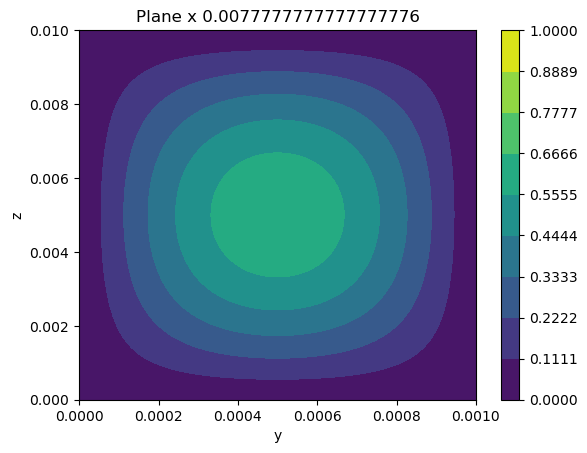

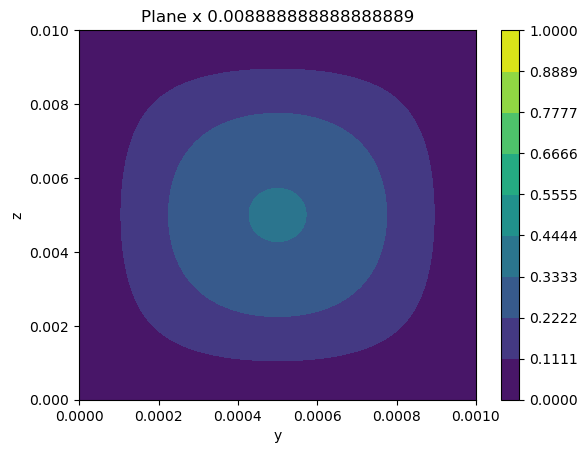

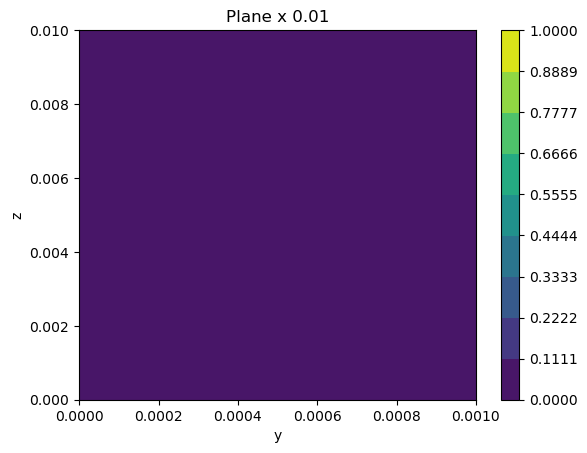

In [188]:
x = np.linspace(0,0.01,10)
for x_ in x:
    acoustic.plot_preassure(x_plane=x_,norm=True)

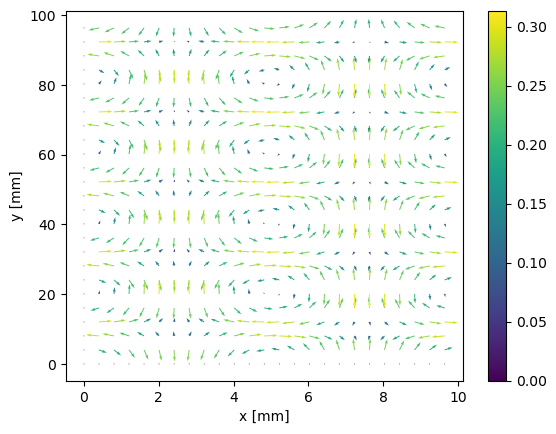

In [184]:
plane=int(250/2)
s = 10
a_ = list(results.keys())[0]
plt.style.use('default')
x,z = np.meshgrid(results[a_]['positions']['x'][::s]*1e3, results[a_]['positions']['y'][::s]*1e3)
u = results[a_]['results']['total'][0][:,:,plane][::s,::s]*1e12
v = results[a_]['results']['total'][1][:,:,plane][::s,::s]*1e12
mag = np.hypot(u,v)
plt.quiver(x,z,u,v, mag)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.colorbar()

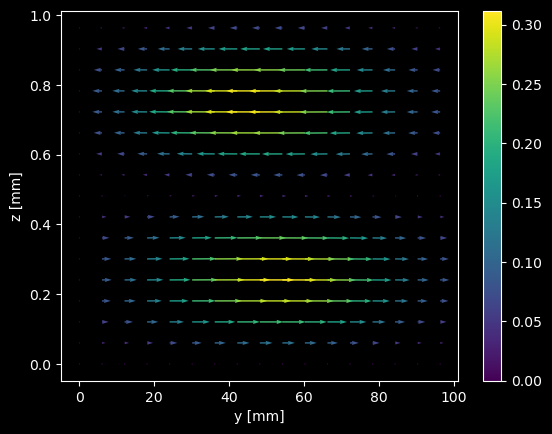

In [103]:
plane=100
s =15
a_ = list(results.keys())[0]
plt.style.use('dark_background')
y,z = np.meshgrid(results[a_]['positions']['y'][::s]*1e3, results[a_]['positions']['z'][::s]*1e3)
u = results[a_]['results']['total'][1][plane,:,:][::s,::s]*1e12
v = results[a_]['results']['total'][2][plane,:,:][::s,::s]*1e12
mag = np.hypot(u,v)
plt.quiver(y,z,u,v, mag)
plt.xlabel('y [mm]')
plt.ylabel('z [mm]')
plt.colorbar()

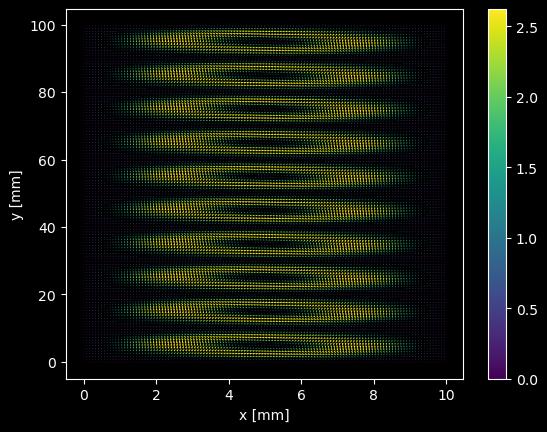

In [57]:
plane=100
s =2
a_ = list(results.keys())[0]
plt.style.use('dark_background')
x,y = np.meshgrid(results[a_]['positions']['x'][::s]*1e3, results[a_]['positions']['y'][::s]*1e3)
u = results[a_]['results']['total'][0][:,:,plane][::s,::s]*1e12
v = results[a_]['results']['total'][1][:,:,plane][::s,::s]*1e12
mag = np.hypot(u,v)
plt.quiver(x,y,u,v, mag)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.colorbar()

In [58]:
def get_components_quiver(x_d,y_d,x_c,y_c,a_,s,plane):
    y,z = np.meshgrid(results[a_]['positions'][x_d][::s]*1e3, results[a_]['positions'][y_d][::s]*1e3)
    if x_c ==0 and y_c == 1:
        u = results[a_]['results']['total'][x_c][:,:,plane][::s,::s]*1e12
        v = results[a_]['results']['total'][y_c][:,:,plane][::s,::s]*1e12
    elif x_c == 0 and y_c ==2:
        u = results[a_]['results']['total'][x_c][:,plane,:][::s,::s]*1e12
        v = results[a_]['results']['total'][y_c][:,plane,:][::s,::s]*1e12
    elif x_c == 1 and y_c == 2:
        u = results[a_]['results']['total'][x_c][plane,:,:][::s,::s]*1e12
        v = results[a_]['results']['total'][y_c][plane,:,:][::s,::s]*1e12
    return y,z,u,v

Text(0.5, 0.98, 'Force vector field xy')

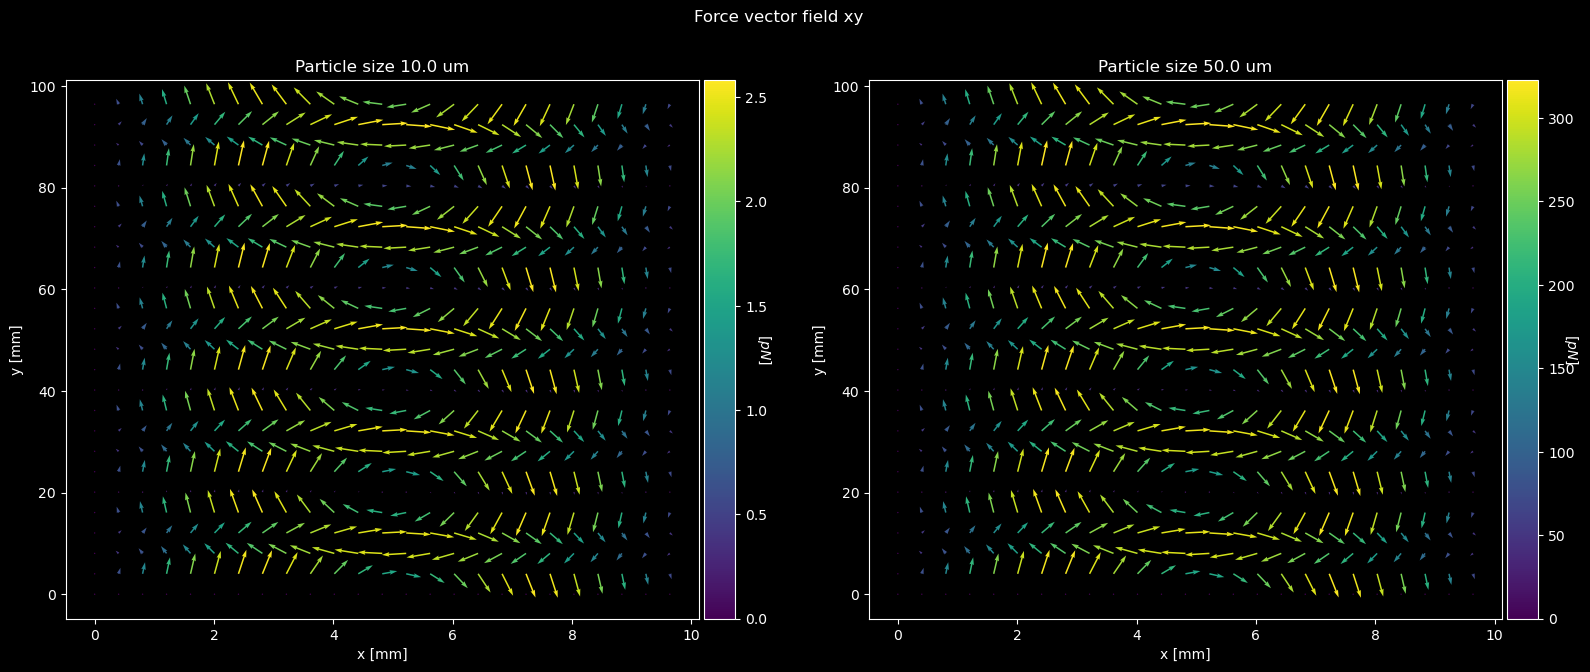

In [98]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plane=100
s =10

plt.style.use('dark_background')
fig,ax = plt.subplots(1,2,figsize=(19,7))
a_ = list(results.keys())[0]
x,y,u,v = get_components_quiver('x','y',0,1,a_,s,plane)
mag = np.hypot(u,v)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im =ax[0].quiver(x,y,u,v, mag)
ax[0].set_xlabel('x [mm]')
ax[0].set_ylabel('y [mm]')
ax[0].set_title(f'Particle size {a_*1e6} um')
# ax[0].quiverkey(im, 0.9, 0.9, 1, r'$[pN]$', labelpos='E',
#                    coordinates='axes')
cbar = fig.colorbar(im,cax=cax)
cbar.set_label(r'$[pN]$',rotation=270)

a_ = list(results.keys())[-1]
x,y,u,v = get_components_quiver('x','y',0,1,a_,s,plane)
mag = np.hypot(u,v)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im =ax[1].quiver(x,y,u,v, mag)
ax[1].set_xlabel('x [mm]')
ax[1].set_ylabel('y [mm]')
ax[1].set_title(f'Particle size {np.round(a_*1e6)} um')
cbar = fig.colorbar(im,cax=cax)
cbar.set_label(r'$[pN]$',rotation=270)
plt.suptitle('Force vector field xy')

In [83]:
ax.shape

(2,)

In [133]:
a_values = np.array([10,15,20,25,50])*1e-6
results_2 = {}
r_i = [0,0,0]
r_f = [0.001,0.001,0.001]
for a in a_values:
    acoustic = AcousticPT('radii',condition='hard-wall',a=a, nx=1, ny=0, nz=1)
    results_2[a] = acoustic.acoustic_force(r_i,r_f,n_points=250)

AcousticPTmodel_condition-hard-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:28<00:00,  8.72it/s]


AcousticPTmodel_condition-hard-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:30<00:00,  8.25it/s]


AcousticPTmodel_condition-hard-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:28<00:00,  8.56it/s]


AcousticPTmodel_condition-hard-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:28<00:00,  8.82it/s]


AcousticPTmodel_condition-hard-wall


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:30<00:00,  8.20it/s]


In [1]:
from mycolorpy import colorlist as mcp
plt.rcParams['figure.dpi'] = (150)
plt.style.use('dark_background')
fig,ax = plt.subplots(3,1, figsize=(18,15))
colormap = mcp.gen_color(cmap='winter',n=(len(a_values)))
plane_val = 1
# fig.suptitle(f'Multiple radii @ according plane {np.round(plane_val/250,2)} mm')
i = 0
for a in results.keys():
    ax[0].plot(results_2[a]['positions']['x'][1:-1]*1e3,results_2[a]['results']['total'][0][:,plane_val,plane_val][1:-1]*1e12,
              label=f'{np.round(a*1e6)}',c=colormap[i])
    ax[1].plot(results_2[a]['positions']['y'][1:-1]*1e3,results_2[a]['results']['total'][1][plane_val,:,plane_val][1:-1]*1e12,
              label=f'{np.round(a*1e6)}',c=colormap[i])
    ax[2].plot(results_2[a]['positions']['z'][1:-1]*1e3,results_2[a]['results']['total'][2][plane_val,plane_val,:][1:-1]*1e12,
              label=f'{np.round(a*1e6)}',c=colormap[i])
    i+=1
comp_lab = {0:'x',1:'y',2:'z'}
for i in range(3):
    ax[i].set_xlabel(f'{comp_lab[i]} position [mm]')
    ax[i].set_title(f'{comp_lab[i].upper()} Component of Force')
    ax[i].set_ylabel('Force [pN]')
    ax[i].legend()
    ax[i].grid()
plt.show()

NameError: name 'plt' is not defined

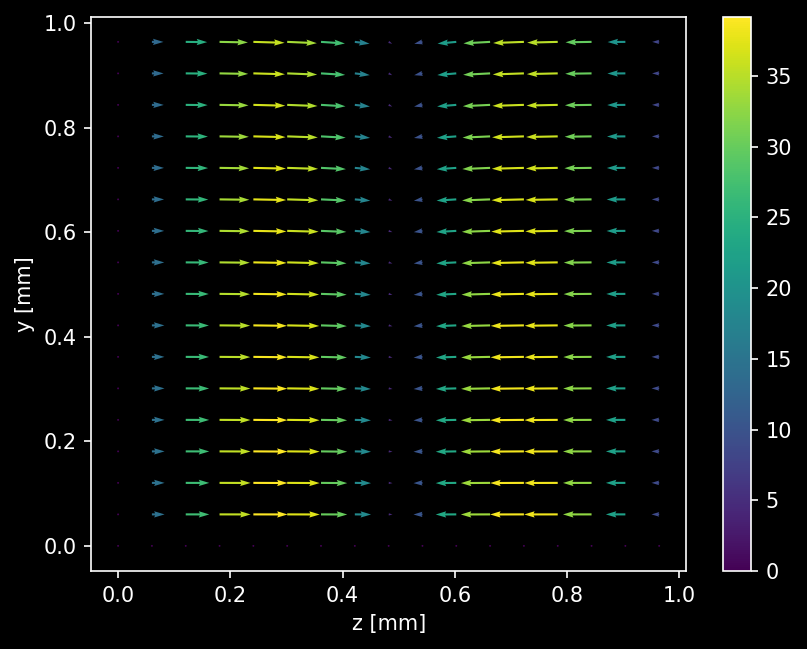

In [161]:
plane=15
s = 15
a_ = list(results.keys())[-1]
plt.style.use('dark_background')
x,z = np.meshgrid(results_2[a_]['positions']['y'][::s]*1e3, results_2[a_]['positions']['z'][::s]*1e3)
u = results_2[a_]['results']['total'][1][plane,:,:][::s,::s]*1e12
v = results_2[a_]['results']['total'][2][plane,:,:][::s,::s]*1e12
mag = np.hypot(u,v)
plt.quiver(x,z,v,u, mag)
plt.xlabel('z [mm]')
plt.ylabel('y [mm]')
plt.colorbar()

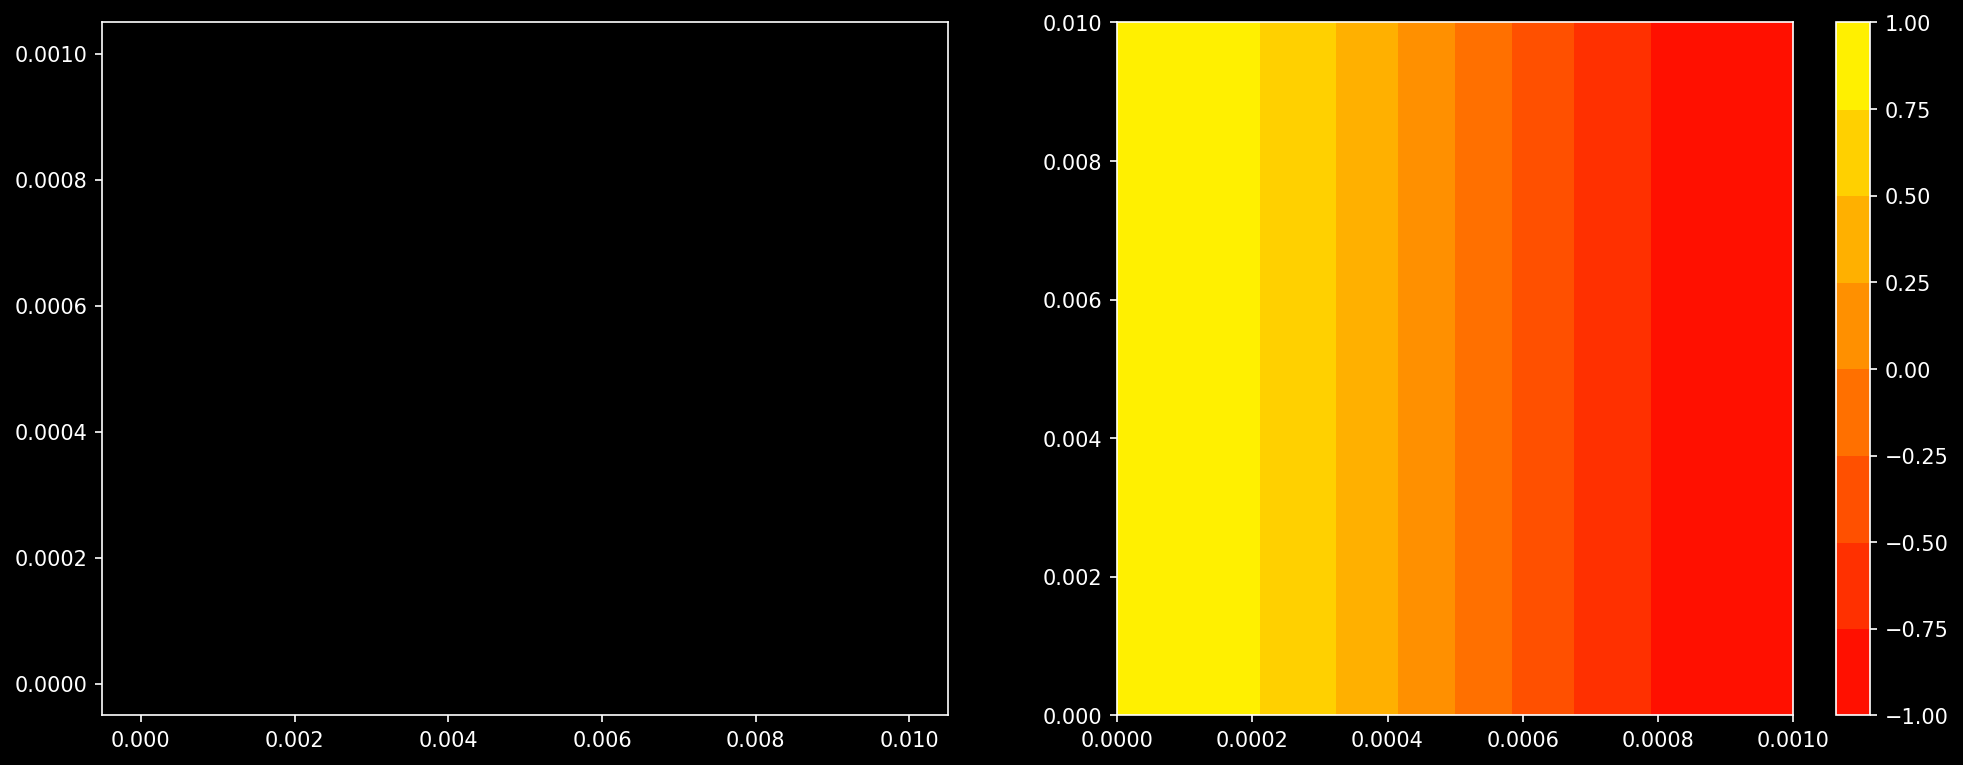

In [163]:
plt.style.use('dark_background')
acoustic.plot_fields(x_plane=0.001,colormap='autumn')

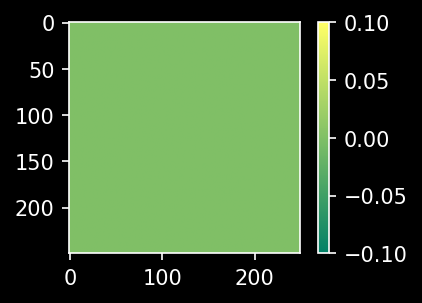

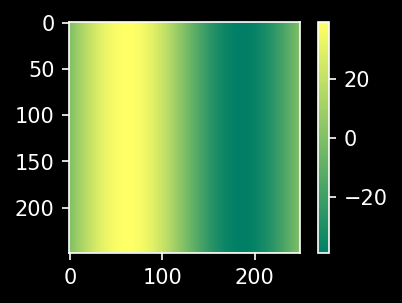

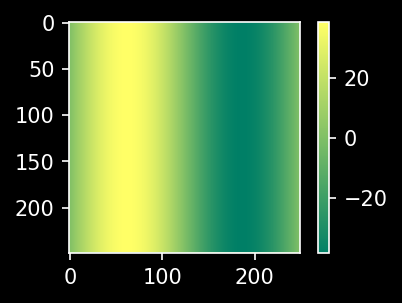

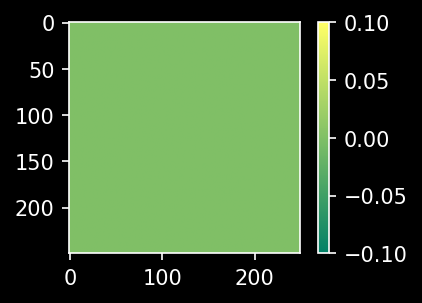

In [172]:
for i in [0,10,100,249]:
    plt.figure(figsize=(3,2))
    plt.imshow(results_2[a_]['results']['total'][2][:,i,:]*1e12,cmap='summer')
    plt.colorbar()
    plt.show()

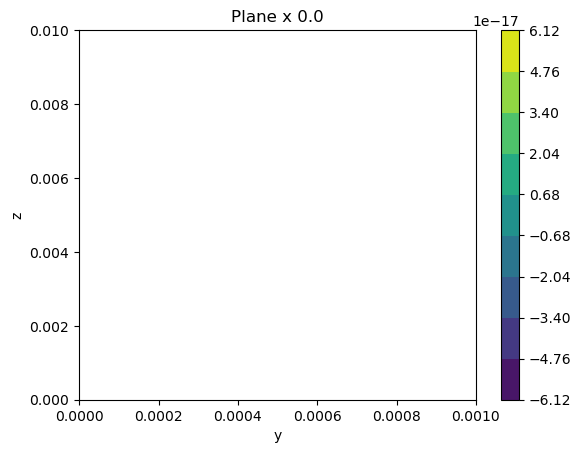

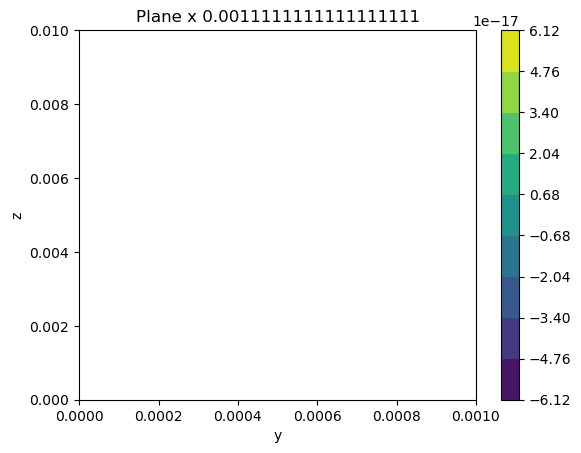

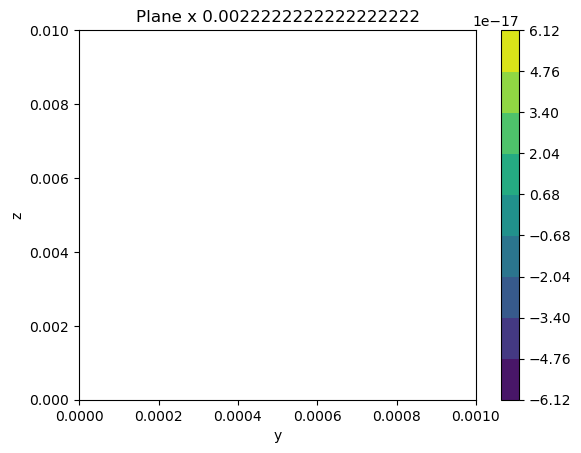

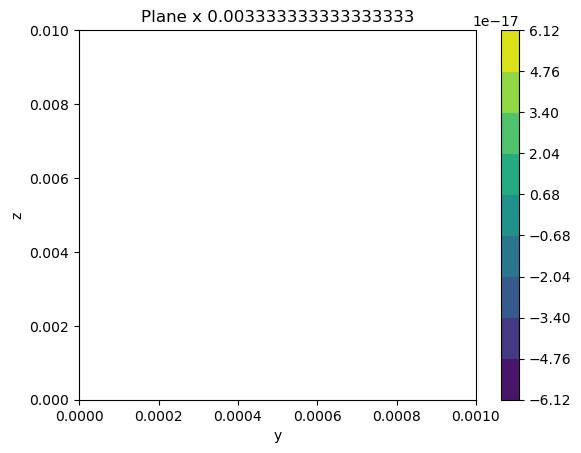

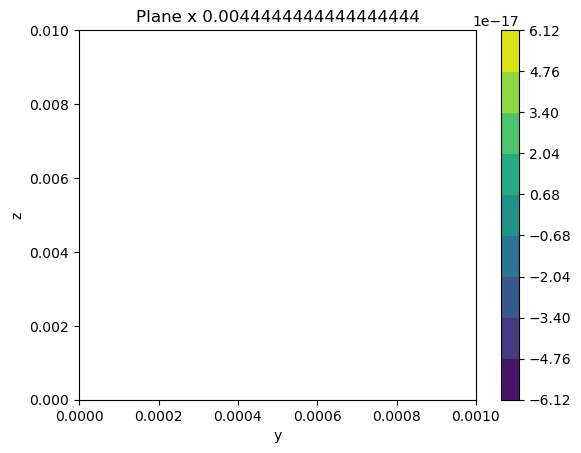

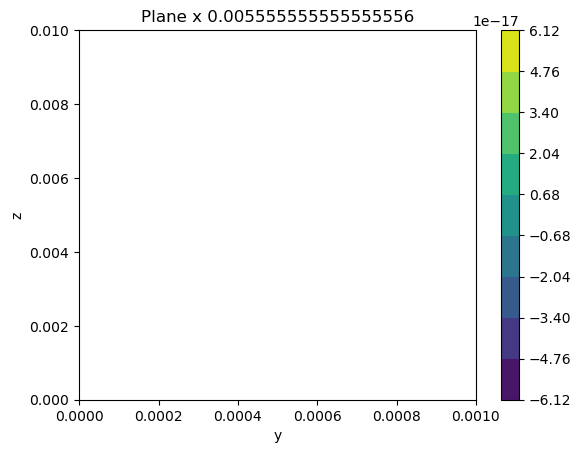

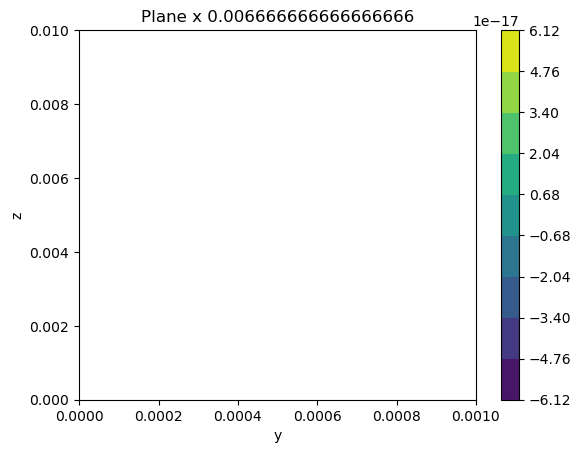

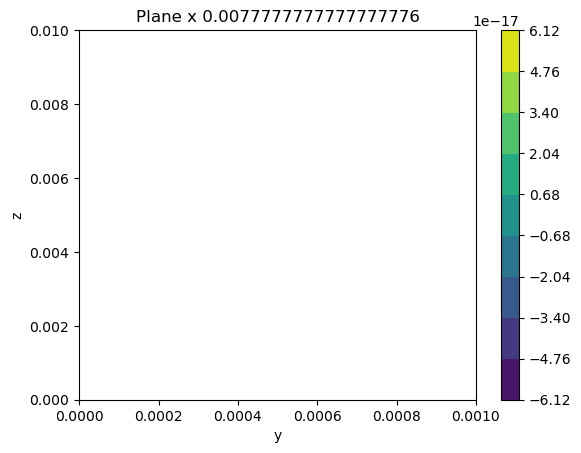

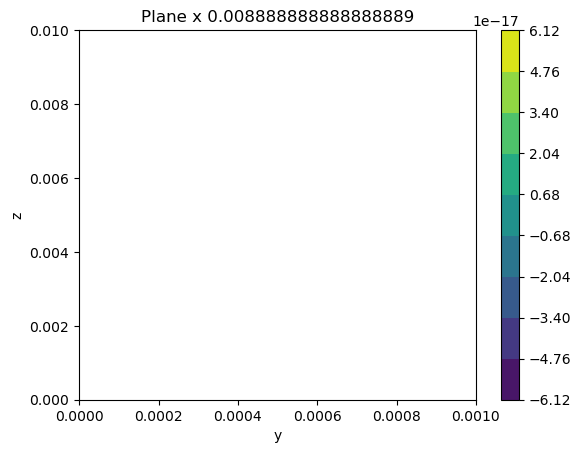

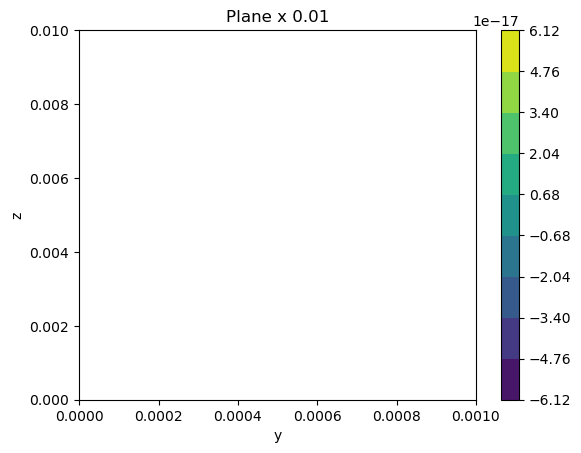

In [174]:
# acoustic.plot_preassure(x_plane=0.01)
x = np.linspace(0,0.01,10)
plt.style.use('default')
for x_ in x:
    acoustic.plot_preassure(x_plane=x_,norm=True)